This notebook constructs a high-res video of MLD in a subset of llc4320 face from MLD-pixels computed in MLD_per_pixel_face.py|

In [ ]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr
import dask

from fastjmd95 import jmd95numba 
from xhistogram.xarray import histogram
from pathlib import Path

import cmocean
import imageio

In [3]:
# first define a helper function to rotate plots for N-S/vertical alignment
def rotate_axes_90_clockwise(ax):
    """
    Robustly rotate a Matplotlib Axes 90 degrees clockwise by:
      - rendering the figure to an RGBA buffer,
      - cropping the pixels belonging to the given Axes,
      - rotating the image 90 deg clockwise,
      - placing the rotated image back into the figure at the same axes position,
      - removing the original Axes.

    Notes:
    - This rasterizes the axis contents (the result is an image, not vector art).
    - Colorbars or other axes that live outside the target `ax` are left alone.
    - Works reliably for full grids or arbitrary subsets.
    """
    fig = ax.figure

    # Force draw so renderer & sizes are correct
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Get pixel bbox of the axes (in display coordinates) via renderer-aware call
    bbox = ax.get_window_extent(renderer=renderer)  # Bbox in display (pixel) coords

    # Grab the full figure RGBA buffer (H x W x 4)
    buf = np.asarray(renderer.buffer_rgba())  # returns an (H,W,4) uint8 array

    H, W = buf.shape[0], buf.shape[1]

    # Convert bbox to integer pixel coords and crop.
    # Note: Bbox y coords are in display coordinates with origin at lower-left.
    x0, x1 = int(np.floor(bbox.x0)), int(np.ceil(bbox.x1))
    y0, y1 = int(np.floor(bbox.y0)), int(np.ceil(bbox.y1))

    # Convert to numpy row indices (origin at top-left)
    row0 = max(0, H - y1)
    row1 = min(H, H - y0)
    col0 = max(0, x0)
    col1 = min(W, x1)

    if row1 <= row0 or col1 <= col0:
        raise RuntimeError("Calculated zero-size axes crop — renderer/coords inconsistent.")

    axes_img = buf[row0:row1, col0:col1, :].copy()  # copy to be safe

    # Rotate 90 degrees clockwise. np.rot90 rotates counterclockwise, so use k=-1 (or k=3).
    rotated = np.rot90(axes_img, k=-1)

    # Create a new axes in the same figure position (figure coords) and show the rotated image.
    # We must compute the original axes position in figure coordinates:
    fig_x0, fig_y0, fig_w, fig_h = ax.get_position().bounds

    # Add overlaid axes and show the rotated image
    new_ax = fig.add_axes([fig_x0, fig_y0, fig_w, fig_h], anchor='C')  # same place
    new_ax.imshow(rotated, origin='upper', aspect='auto')
    new_ax.set_axis_off()

    # Remove the original axes (so only rotated image remains)
    fig.delaxes(ax)

    # Force redraw
    fig.canvas.draw()
    return new_ax

# function to get i,j indices from target lat/lon vals
def i_j_from_lat_lon(coord_centers, num_boxes, coord_min):
    i = []
    j = []
    for box in range(int(num_boxes)):
        # get lat/lon in increments
        target = coord_min + 0.1 * box

        # get index closest to lat/lon targets
        dist = np.abs(coord_centers - target)
        flat_idx = np.nanargmin(dist)
        i_, j_ = np.unravel_index(flat_idx, coord_centers.shape)
        
        i.append(int(i_)), j.append(int(j_))
    return i, j

# function to get lat/lon vals from i, j indices
def lat_lon_from_i_j(LLC):
    lats = []
    lons = []
    lats.append(LLC['YC'][0,:].values)
    lons.append(LLC['XC'][:,0].values)

    return lats, lons

In [4]:
data_dir = '/orcd/data/abodner/002/cody/MLD_per_pixel'
data = 'MLD_test_face7_(432,9192)_((2000, 2540))'
MLD_per_pixel = xr.open_zarr(f'{data_dir}/{data}.zarr',consolidated=False)
llc = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [5]:
t1 = MLD_per_pixel.isel(time=0)


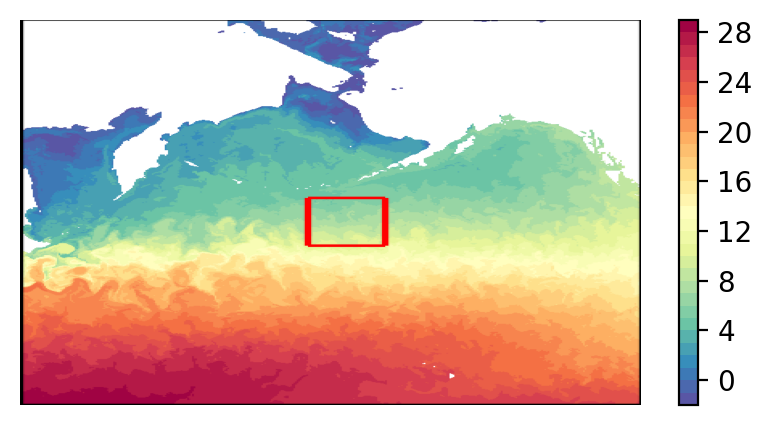

In [6]:
# extract box i,j extents
i_0 = t1.i.values.min()
i_1 = t1.i.values.max()
j_0 = t1.j.values.min()
j_1 = t1.j.values.max()

# let's visualize loc of interest
llc_vis = llc.isel(time=2000,face=7, k=14)
fig, ax = plt.subplots(figsize=(5,2.5),dpi=200)
cf = ax.contourf(llc_vis['Theta']['i'], llc_vis['Theta']['j'], llc_vis['Theta'], cmap="Spectral_r",vmin=np.min(llc_vis['Theta']).values,vmax=np.max(llc_vis['Theta']).values, levels = 30)

ax.hlines(y=j_0, xmin=i_0, xmax=i_1, colors='r')
ax.hlines(y=j_1, xmin=i_0, xmax=i_1, colors='r')
ax.vlines(x=i_0, ymin=j_0, ymax=j_1, colors='r')
ax.vlines(x=i_1, ymin=j_0, ymax=j_1, colors='r')

plt.colorbar(cf, ax = ax)
ax.set_xlim(0,4320)

rotate_axes_90_clockwise(ax)

plt.show()

Text(0, 0.5, 'Latitude')

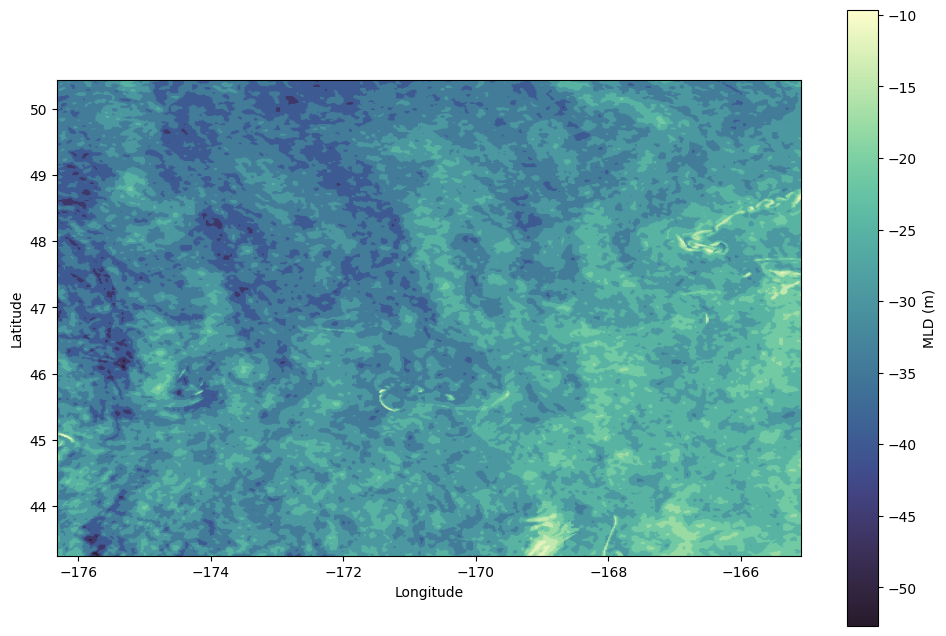

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

contours = ax.imshow(
    t1["MLD_pixels"],
    extent=[
        float(t1.XC.min()), float(t1.XC.max()),
        float(t1.YC.min()), float(t1.YC.max()),
    ],
    origin="lower",
    cmap = cmocean.cm.deep_r
)

plt.colorbar(contours, ax=ax, label="MLD (m)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [ ]:
MLD_daily = MLD_per_pixel.resample(time="D").mean()
monthly_min = MLD_daily.MLD_pixels.resample(time="MS").min(("time", "i", "j"))
monthly_max = MLD_daily.MLD_pixels.resample(time="MS").max(("time", "i", "j"))

MLD_daily, monthly_min, monthly_max = dask.compute(
    MLD_daily, monthly_min, monthly_max
)

ValueError: Invalid frequency: 1Day, failed to parse with error message: ValueError("Invalid frequency: DAY, failed to parse with error message: KeyError('DAY')")

In [26]:
t = 15
t1 = MLD_monthly.isel(time=t)

vmin = float(monthly_min.isel(time=t))
vmax = float(monthly_max.isel(time=t))

fig, ax = plt.subplots(figsize=(12,8))

im = ax.imshow(
    t1["MLD_pixels"],
    extent=[
        float(t1.XC.min()), float(t1.XC.max()),
        float(t1.YC.min()), float(t1.YC.max()),
    ],
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap=cmocean.cm.deep_r
)

# Month label
month_str = np.datetime_as_string(t1.time, unit="M")
ax.set_title(f"MLD — {month_str}")

plt.colorbar(im, ax=ax, label="MLD (m)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

IndexError: index 15 is out of bounds for axis 0 with size 12

KeyboardInterrupt: 

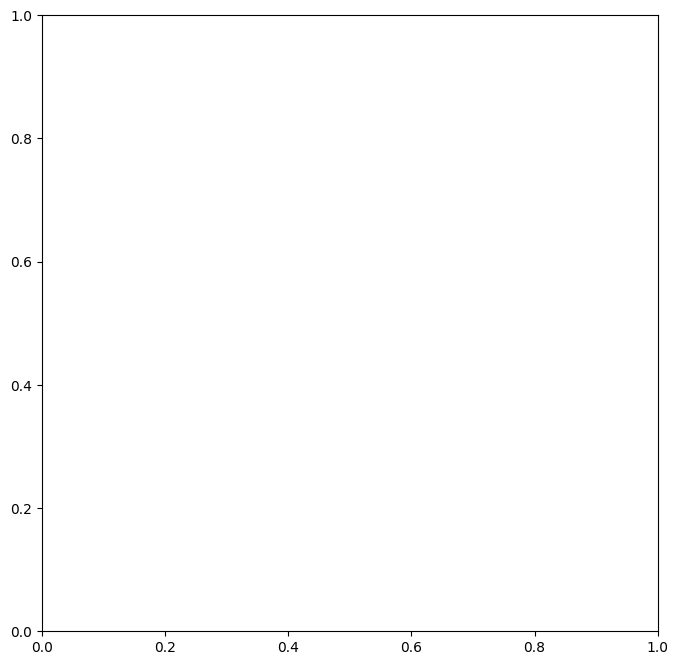

In [ ]:
frames = Path("frames")
frames.mkdir(exist_ok=True)

for n, t in enumerate(MLD_monthly.time.values):

    t1 = MLD_monthly.sel(time=t)

    vmin = float(monthly_min.sel(time=t))
    vmax = float(monthly_max.sel(time=t))

    fig, ax = plt.subplots(figsize=(8,5))

    im = ax.imshow(
        t1["MLD_pixels"],
        extent=[
            float(t1.XC.min()), float(t1.XC.max()),
            float(t1.YC.min()), float(t1.YC.max()),
        ],
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        cmap=cmocean.cm.deep_r
    )

    # Month label
    month_str = np.datetime_as_string(t, unit="M")
    ax.set_title(f"MLD — {month_str}")

    plt.colorbar(im, ax=ax, label="MLD (m)")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    fig.savefig(frames / f"{n:04d}.png", dpi=100)
    plt.close()

In [ ]:
# Path to frames
frames_dir = Path("frames")
frame_files = sorted(frames_dir.glob("*.png"))  # ensure correct order

# Output video file
output_file = "MLD_ts.mp4"

# Frames per second
fps = 60

# Write video
with imageio.get_writer(output_file, fps=fps) as writer:
    for frame_file in frame_files:
        image = imageio.imread(frame_file)
        writer.append_data(image)

print(f"Video saved to {output_file}")

/tmp/ipykernel_698724/899235466.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_file)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 1200) to (1808, 1200) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


: 